In [32]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

# Set the environment variable to suppress TensorFlow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# custom classes and functions
import models
from models.blocks import ConvBlock, TransposeConvBlock, ResConvBlock, CategoricalStraightThrough
from models.mlp import MLP
from models.autoencoder import Autoencoder
from models.vae import VAE
from models.categorical_vae import CategoricalVAE
from models.sequential_categorical_vae import SeqCatVAE
from preprocessing import grayscale_transform as transform

%matplotlib inline

In [17]:
to_np = lambda x: x.detach().cpu().numpy() 

In [18]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Set Hyperparameters

In [19]:
batch_size = 8

A = 3 # number of action dimensions (3 for toy, 2 for real sim)
H = 512 # discrete h state 
num_categoricals = 32
num_classes = 32
Z = num_categoricals * num_classes # stochastic Zx1 state

## RSSM

In [20]:
class RSSM(nn.Module):
    def __init__(self):
        super(RSSM, self).__init__()
        
        # init the VAE
        self.vae = SeqCatVAE(H, Z, grayscale=True, vae_ent_coeff=1e-8)
        
        # init the RNN
        self.num_rnn_layers = 1
        self.rnn = nn.GRU(input_size=A+H+Z, hidden_size=H, num_layers=self.num_rnn_layers)
        
        # init MLPs
        self.dynamics_mlp = MLP(input_dims=H, output_dims=Z) # H -> Z
        self.reward_mlp = MLP(input_dims=H+Z, output_dims=1) # state (H+Z) -> 1
        self.continue_mlp = MLP(input_dims=H+Z, output_dims=1) # state (H+Z)->1 # add sigmoid and BinaryCE  
    
    def step(self, action, h, z):

        # concatenate the rnn_input and apply RNN to obtain the next hidden state
        rnn_input = torch.cat((action, h.view(-1, H), z), 1)
        _, h = self.rnn(rnn_input, h.view(-1, H))
        
        state = torch.cat((h.view(-1, H), z), 1)
        
        # predict the reward and continue flag
        reward_pred = rssm.reward_mlp(state)
        continue_prob = torch.sigmoid(rssm.continue_mlp(state)) # binary classification
        continue_pred = bool(continue_prob > 0.5)
        
        x_reconstruction = rssm.vae.decode(h, z)
        
        
        return h, reward_pred, continue_prob, continue_pred, x_reconstruction
    
    def get_losses(self,
                   x_target, x_pred, 
                   reward_target, reward_pred, 
                   continue_target, continue_prob, 
                   z_pred, z):
        
        image_loss = F.mse_loss(x_target, x_pred, reduction="mean")
        reward_loss = F.mse_loss(reward_target.squeeze(), reward_pred.squeeze(), reduction="mean")
        continue_loss = F.binary_cross_entropy(continue_prob.squeeze(), continue_target.squeeze())
        
        # DreamerV3 KL losses: regularize the posterior (z) towards the prior (z_pred)
        kld = dist.kl.kl_divergence
        
        # define the distributions with grad
        dist_z = dist.OneHotCategorical(probs=z.view(-1, num_categoricals, num_classes))
        dist_z_pred = dist.OneHotCategorical(probs=z_pred.view(-1, num_categoricals, num_classes))
        
        # define the distributions without grad
        dist_z_sg = dist.OneHotCategorical(probs=z.detach().view(-1, num_categoricals, num_classes))
        dist_z_pred_sg = dist.OneHotCategorical(probs=z_pred.detach().view(-1, num_categoricals, num_classes))

        # calculate the mean KL-divergence across the categoricals
        
        dyn_loss = torch.max(torch.tensor(1), torch.mean(kld(dist_z_sg, dist_z_pred)))
        rep_loss = torch.max(torch.tensor(1), torch.mean(kld(dist_z, dist_z_pred_sg)))
        
        # print("dyn_loss:", dyn_loss, ", rep_loss:", rep_loss)
        
        # calculate the combined loss
        loss = 1.0 * (image_loss + reward_loss + continue_loss) + 0.5 * dyn_loss + 0.1 * rep_loss
        
        return {"loss": loss, "image_loss": image_loss, "reward_loss": reward_loss, 
                "continue_loss": continue_loss, "dyn_loss": dyn_loss, "rep_loss": rep_loss}
    
    # def info(self):
    # - look at VAE.info() 
    
    # def print_num_params(self):
    #     print(f"RSSM ==> number of parameters: {sum(p.numel() for p in rssm.parameters() if p.requires_grad):_}")

### Test area

In [41]:
rssm = RSSM().to(device)

rssm_optim = optim.Adam(
    rssm.parameters(), 
    lr=3e-4,
    weight_decay=1e-8 # l2 regularization
)

value_net = MLP(input_dims=Z, output_dims=1).to(device) # state (H+Z) -> 1
policy_net = MLP(input_dims=Z, output_dims=A).to(device) # state (H+Z) -> A

## Training loop

In [43]:
""" training loop """

toy_env = True
verbose = True
n_episodes = 1000
rssm.train()

# Create the environment
if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=100, render_mode="rgb_array") # rgb_array/human # 50 steps
else:
    assert A==2
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-generated-roads-v0", # donkey-minimonaco-track-v0 
        max_episode_steps=100,
        make_kwargs={
            "conf": config
        })

# Logging
log_dir = "logs/"
writer = SummaryWriter(log_dir)
notebook.start(f"--logdir={log_dir}")

episode_losses = { # for loss plots
    "episode_loss": [],
    "episode_image_loss": [],
    "episode_reward_loss": [],
    "episode_continue_loss": [],
    "episode_dyn_loss": [],
    "episode_rep_loss": [],
}

try:
    for episode in tqdm(range(n_episodes)):

        # Get the initial state
        obs, info = env.reset()

        # Reset the RNN's hidden state
        h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H

        # Add a new loss for the current episode and initialize it to 0
        episode_length = 0
        for key in episode_losses:
            episode_losses[key].append(torch.tensor(0, device=device, dtype=torch.float32))

        # Play one episode
        done = False
        while not done:

            x = transform(obs).view(-1, 1, 128, 128)

            """ WORLD MODEL LEARNING """

            # predict z and generate the true stochastic latent variable z with the encoder
            z_pred = rssm.dynamics_mlp(h).view(-1, num_categoricals, num_classes) # (1,32,32) for the softmax
            z_pred = F.softmax(z_pred, -1).view(-1, Z) # flatten to (1, 1024)
            z = rssm.vae.encode(h, x).view(-1, Z)

            # apply external actor and critic nets on z
            action = policy_net(z) # Ax1 vector
            v = value_net(z)

            # predict one step using the RSSM and apply the actor-critic
            h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)

            # choose and execute an action
            next_obs, reward, terminated, truncated, info = env.step(to_np(action.squeeze()))        

            done = terminated or truncated
            obs = next_obs

            # calculate the loss
            continue_target = torch.tensor(1 - done, device=device, dtype=torch.float32)
            reward = torch.tensor(reward, device=device, dtype=torch.float32)

            # TODO: z_prior, z_posterior
            z_prior = torch.tensor(0, device=device, dtype=torch.float32)
            z_posterior = torch.tensor(0, device=device, dtype=torch.float32)

            losses = rssm.get_losses(x, x_pred, reward, reward_pred, 
                                     continue_target, continue_prob, z_pred, z)

            # Add loss for the current step to the episode loss
            episode_length += 1
            for key in losses:
                episode_losses["episode_" + key][-1] += losses[key]

        # Calculate the mean loss of the episode
        for key in episode_losses:
            episode_losses[key][-1] /= episode_length

        # update the world model at the end of an episode using the mean loss of the episode
        rssm_optim.zero_grad()
        episode_losses["episode_loss"][-1].backward()
        nn.utils.clip_grad_norm_(rssm.vae.parameters(), max_norm=1.0, norm_type=2)  
        rssm_optim.step()

        # Detach the losses to save memory and log them in TensorBoard
        for key in episode_losses:
            episode_losses[key][-1] = episode_losses[key][-1].detach().item()
            writer.add_scalar(key, episode_losses[key][-1], global_step=episode)

    env.close()

except KeyboardInterrupt:
    """ Clean handling for interrupts to stop training early """
    print("Stopping training.")
    # Delete the last loss if the training was stopped early
    # so that the list only consists of floats
    for key in episode_losses:
        if isinstance(episode_losses[key][-1], torch.Tensor):
            episode_losses[key] = episode_losses[key][:-1]

    # Close the TensorBoard writer and the gym environment
    writer.close()
    env.close()

 30%|█████████████████████████▉                                                              | 295/1000 [06:12<14:50,  1.26s/it]

Stopping training.


In [ ]:
# GPU memory consumption:
# 10 steps -> 6504MiB
# 50 steps -> 19990MiB

## Plot results

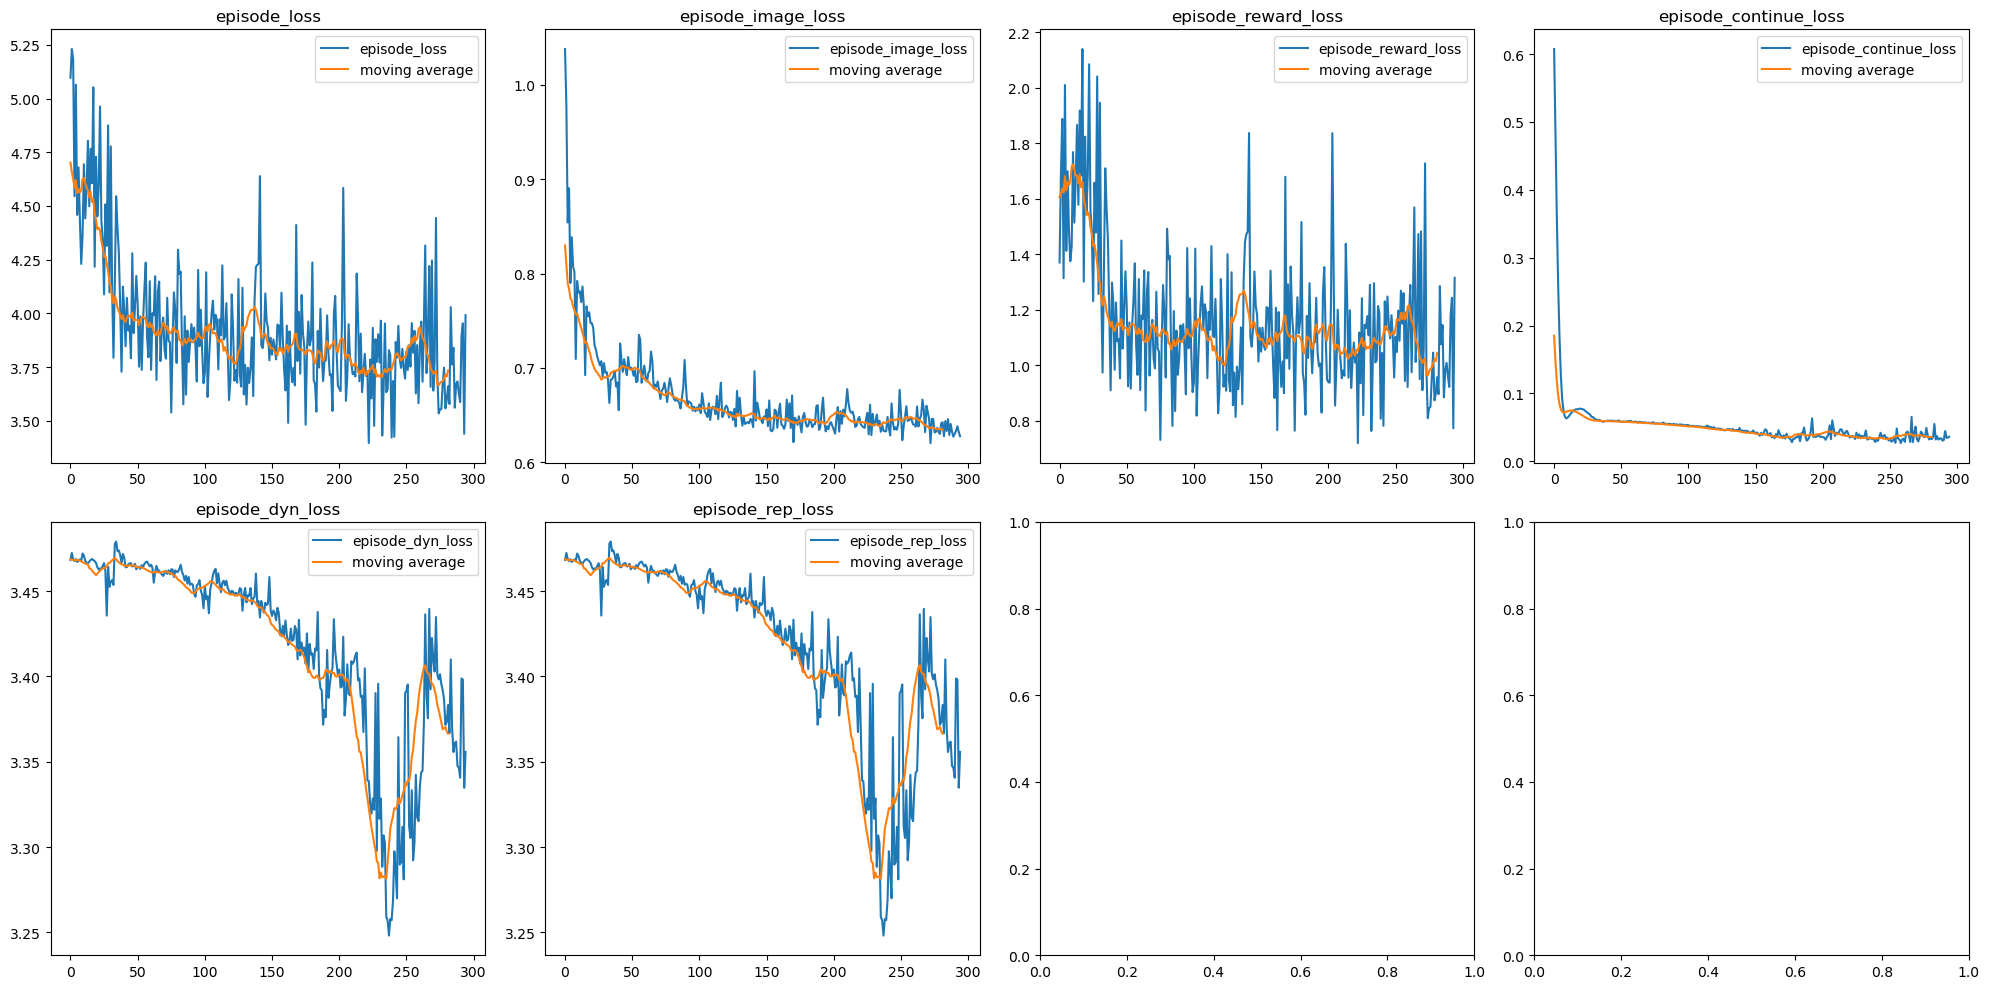

In [44]:
# Delete the last loss if the training was stopped early
# so that the list only consists of floats
for key in episode_losses:
    if isinstance(episode_losses[key][-1], torch.Tensor):
        episode_losses[key] = episode_losses[key][:-1]

rolling_length = max(1, int(len(episode_losses["episode_loss"])/20))

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4*5, 2*5))

# Iterate over the keys and plot the losses
for i, key in enumerate(episode_losses.keys()):
    row = i // 4
    col = i % 4

    axs[row, col].set_title(key)
    losses = episode_losses[key]
    losses_moving_average = (
        np.convolve(
            np.array(losses).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[row, col].plot(range(len(losses)), losses, label=key)
    axs[row, col].plot(range(len(losses_moving_average)), losses_moving_average, label="moving average")
    axs[row, col].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Test area

# Overfitting and visualization playground

In [ ]:
""" overfit to one sample to test whether the VAE works """
overfit = False

if overfit:
    batch_tensor = torch.load("batch_tensor.pt").to(device)
    vae_losses, reconstruction_losses, entropy_losses = [], [], []
    
    for i in range(200):
        
        xhat = vae(batch_tensor)
    
        # get a loss and update the autoencoder
        vae_loss, reconstruction_loss, entropy_loss = vae.get_loss(batch_tensor, xhat)
        vae_optim.zero_grad()
        vae_loss.backward()
        vae_optim.step()
    
        vae_losses.append(vae_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        entropy_losses.append(entropy_loss.item())
    
        if i % 20 == 0:
            print(f"[{i+1}/{200}] loss: {vae_loss.item()}, entropy loss: {entropy_loss}, lr: {get_lr(vae_optim)}")

In [46]:
visualize = False

if visualize:
    if toy_env:
        x = torch.load("batch_tensor_toy.pt").to(device)
        h = torch.load("h_tensor.pt").to(device)
    else:
        x = torch.load("batch_tensor.pt")[0].unsqueeze(dim=0).to(device)
        h = torch.load("h_tensor.pt").to(device)
    
    """ show the observation """
    plt.imshow(torch.permute(x[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
    
    """ show the reconstruction """
    rssm.vae.eval()
    with torch.no_grad():
        x_pred = rssm.vae(h, x)
        plt.imshow(torch.permute(x_pred[0].cpu(), (1,2,0)), cmap="gray")
        plt.show()
    rssm.vae.train();